## HomeWork

现有一张咖啡图`cof`，和一个给定模式的退化模糊核`psf`，请初始化一个`(9,9,3)`的矩阵`psf_init`并尽量优化至`psf`的情况（只能使用`img` 和 `img_deg` 的数据）。

我们将讨论几个内容：

- 频域优化和空域优化有什么区别？
- 初始值的选择是否会有差异？
- 数值精度的选择是否会有差异？
- 如何评估最终的优化效果？

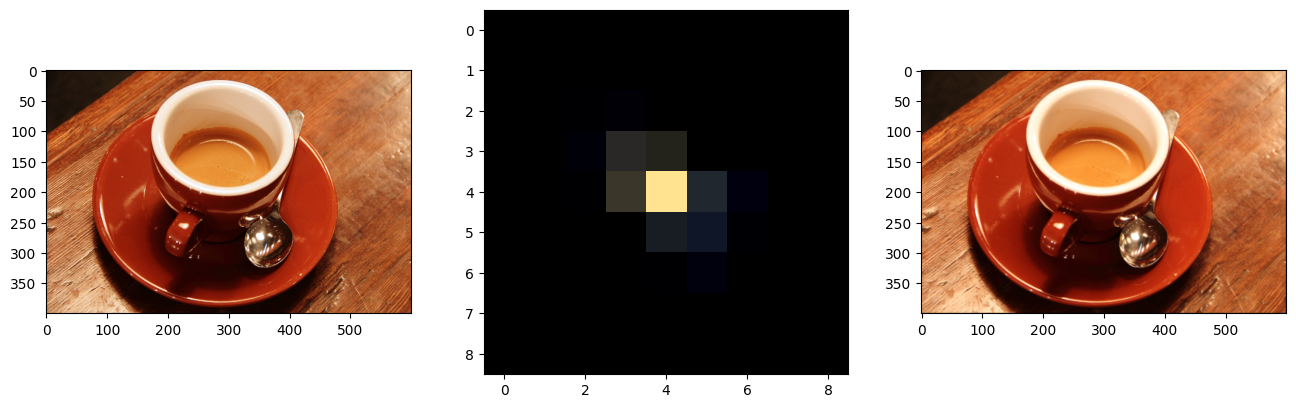

In [1]:
import torch
import scipy.io as scio
import numpy as np
from skimage import data
import matplotlib.pyplot as plt

torch.manual_seed(555)

@torch.no_grad()
def eval_psnr(img, ref):
    pixel_max = torch.amax(ref, (-2, -1))
    mse = torch.mean((img - ref) ** 2, dim=(-2, -1))
    psnr = torch.mean(20. * torch.log10(pixel_max / torch.sqrt(mse)))
    return psnr

# load the image
cof = data.coffee().astype(np.float64) / 255.
# convert to tensor
cof = torch.tensor(cof).unsqueeze(0).permute(0, 3, 1, 2) # [B, C, H, W]
psf = np.array(scio.loadmat('./static/psf.mat')['psf'].astype(np.float64))
psf = np.clip(psf, 0., 1.)
psf = psf[::-1, ::-1, ...].copy()
psf = torch.tensor(psf).unsqueeze(0).permute(3, 0, 1, 2) # [i_ch, o_ch, h, w]

cof_deg = torch.nn.functional.conv2d(cof, psf, padding=int((psf.shape[-1]-1)/2), groups=3)

# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 16))
ax1.imshow(cof.squeeze(0).permute(1, 2, 0).numpy())
ax2.imshow(psf.squeeze(1).permute(1, 2, 0).numpy()[::-1, ::-1, ...]/
           np.max(psf.squeeze(1).permute(1, 2, 0).numpy()[::-1, ::-1, ...]))
ax3.imshow(np.clip(cof_deg.squeeze(0).permute(1, 2, 0).numpy(), 0., 1.))

首先我们试试在空域进行模糊核估计，这是一个更直观的想法：

iteration: <0>, loss: <4.285193787564278>
iteration: <1000>, loss: <0.25081709244700956>
iteration: <2000>, loss: <0.15210762857930665>
iteration: <3000>, loss: <0.1022126717011457>
iteration: <4000>, loss: <0.06892122413540153>
iteration: <5000>, loss: <0.05478284349858677>
iteration: <6000>, loss: <0.040892386824204735>
iteration: <7000>, loss: <0.02849429832159959>
iteration: <8000>, loss: <0.018433875179873556>
iteration: <9000>, loss: <0.014002534390355325>
iteration: <10000>, loss: <0.009814084129852258>
iteration: <11000>, loss: <0.006292608390802391>
iteration: <12000>, loss: <0.003638097396566186>
iteration: <13000>, loss: <0.0025753911674036047>
iteration: <14000>, loss: <0.0016745910782992434>
iteration: <15000>, loss: <0.001003080014100744>
iteration: <16000>, loss: <0.000562510751635998>
iteration: <17000>, loss: <0.00040095843288813607>
iteration: <18000>, loss: <0.0002647179863046038>
iteration: <19000>, loss: <0.0001650775769284867>


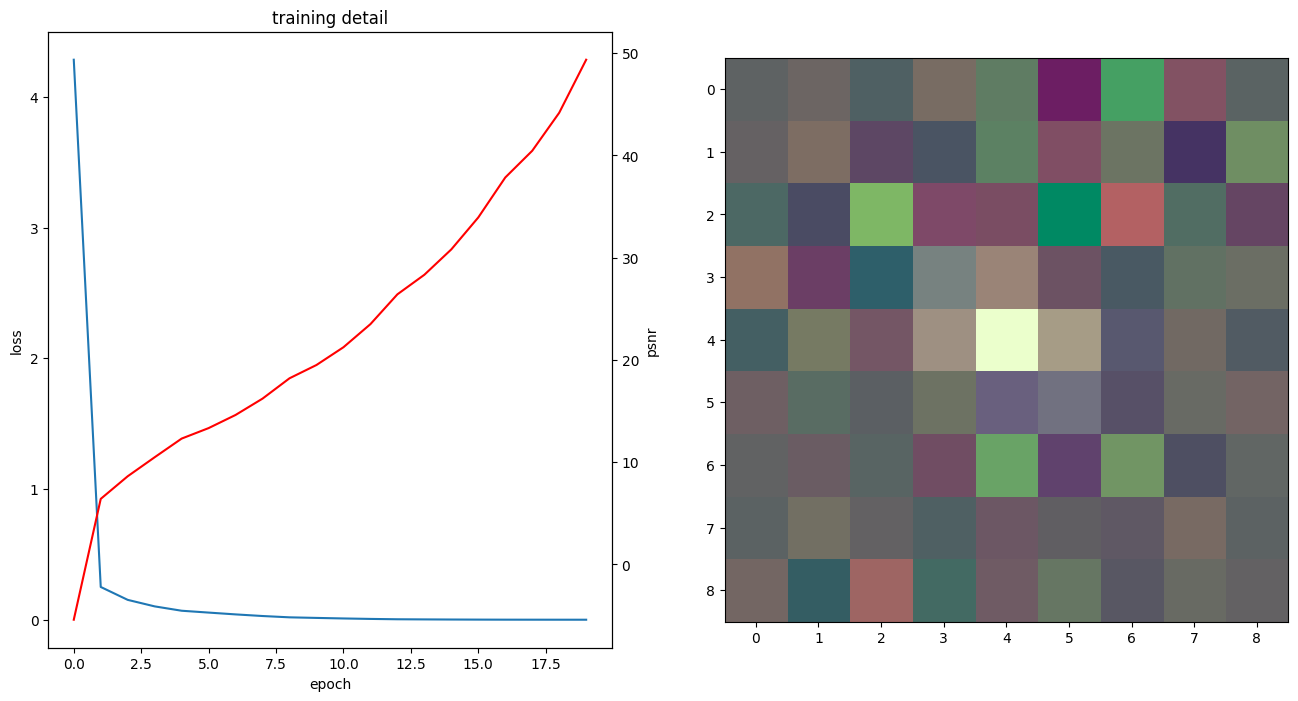

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
num_epochs = 20000
loss_fn = torch.nn.MSELoss().to(device)
psf_init = torch.randn_like(psf).to(device)
psf_init.requires_grad = True # first to device than set require grad for initializing as a leaf node
cof, cof_deg = cof.to(device), cof_deg.to(device)
optimizer = torch.optim.Adam([psf_init], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_epochs//5, gamma=0.5)

record_freq = 1000
record_log = {'loss':[], 'psf':[], 'psnr':[]}
for iter in range(num_epochs):
    prediction = torch.nn.functional.conv2d(cof, psf_init, padding=int((psf_init.shape[-1]-1)/2), groups=3)
    loss = loss_fn(prediction, cof_deg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if iter % record_freq == 0:
        record_log['loss'].append(loss.detach().cpu().item())
        record_log['psf'].append(psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...])
        record_log['psnr'].append(eval_psnr(prediction, cof_deg).cpu().item())
        print('iteration: <{}>, loss: <{}>'.format(iter, loss.detach().cpu().item()))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(range(0, num_epochs//record_freq), np.array(record_log['loss']))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1 = ax1.twinx()
ax1.plot(range(0, num_epochs//record_freq), np.array(record_log['psnr']), color='red')
ax1.set_ylabel('psnr')
ax2.imshow((record_log['psf'][-1] - record_log['psf'][-1].min())/
           (record_log['psf'][-1].max() - record_log['psf'][-1].min()))
plt.title('training detail')
plt.show()

可以看到直接初始化一个随机的kernel进行优化的话，由于缺少物理先验的约束，最终的结果并不会准确。这样优化的过程由于缺少物理上的先验信息，优化得到的结果只能说是在数值上对于原始图像到退化图像映射过程的数值逼近，并不是一个真实的点扩散函数。

所以，我们可以先考虑加入一些物理信息的先验：

1. 从频域估计一个初始解，然后进行迭代优化

2. 监督点扩散函数的各通道和为1

频域估计初始解

iteration: <0>, loss: <0.003534692837486428>
iteration: <1000>, loss: <2.3393688314504645e-06>
iteration: <2000>, loss: <4.471105509240571e-07>
iteration: <3000>, loss: <1.269173530469479e-07>
iteration: <4000>, loss: <2.5849273240367638e-05>
iteration: <5000>, loss: <2.5526024365983793e-08>
iteration: <6000>, loss: <1.1986364341596146e-08>
iteration: <7000>, loss: <5.524851083984531e-09>
iteration: <8000>, loss: <2.627113116881675e-09>
iteration: <9000>, loss: <1.580449565600607e-09>
iteration: <10000>, loss: <7.784365394922595e-10>
iteration: <11000>, loss: <2.1745773878962557e-07>
iteration: <12000>, loss: <1.901865411810217e-10>
iteration: <13000>, loss: <1.2128286834942918e-10>
iteration: <14000>, loss: <6.266503906275934e-11>
iteration: <15000>, loss: <3.173089094428759e-11>
iteration: <16000>, loss: <1.6087161220747938e-11>
iteration: <17000>, loss: <1.0544127349921495e-11>
iteration: <18000>, loss: <7.654092583517503e-11>
iteration: <19000>, loss: <2.912878601215017e-12>


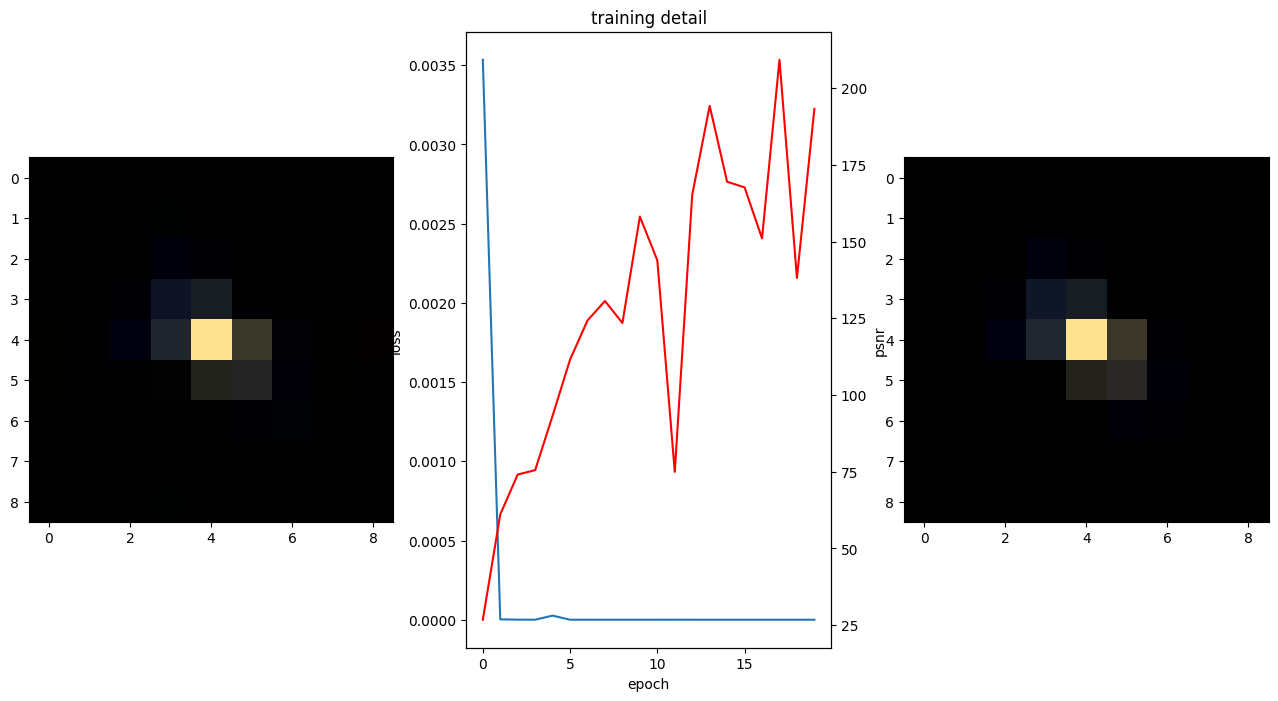

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
num_epochs = 20000
psf_chn = []
for i in range(0,3):
    F = torch.fft.fft2(cof[0,i,:,:])
    G = torch.fft.fft2(cof_deg[0,i,:,:])
    H = G/F

    h = torch.fft.ifft2(H)
    h = torch.fft.fftshift(h)
    h = h[196:205,296:305] # [9, 9]
    h = h.abs()
    h = h.unsqueeze(0)
    psf_chn.append(h.unsqueeze(1))
psf_init = torch.concatenate((psf_chn[0], psf_chn[1], psf_chn[2]),dim=0)
psf_init = psf_init.to(device)
psf_init.requires_grad = True
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
ax1.imshow((psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...] - 
           psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...].min())/
           (psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...].max() - 
           psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...].min()))

loss_fn = torch.nn.MSELoss().to(device)
cof, cof_deg = cof.to(device), cof_deg.to(device)
optimizer = torch.optim.Adam([psf_init], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_epochs//5, gamma=0.5)

record_freq = 1000
record_log = {'loss':[], 'psf':[], 'psnr':[]}
for iter in range(num_epochs):
    prediction = torch.nn.functional.conv2d(cof, psf_init, padding=int((psf_init.shape[-1]-1)/2), groups=3)
    loss = loss_fn(prediction, cof_deg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if iter % record_freq == 0:
        record_log['loss'].append(loss.detach().cpu().item())
        record_log['psf'].append(psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy())
        record_log['psnr'].append(eval_psnr(prediction, cof_deg).cpu().item())
        print('iteration: <{}>, loss: <{}>'.format(iter, loss.detach().cpu().item()))

ax2.plot(range(0, num_epochs//record_freq), np.array(record_log['loss']))
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2 = ax2.twinx()
ax2.plot(range(0, num_epochs//record_freq), np.array(record_log['psnr']), color='red')
ax2.set_ylabel('psnr')
ax3.imshow((record_log['psf'][-1] - record_log['psf'][-1].min())/
           (record_log['psf'][-1].max() - record_log['psf'][-1].min()))
plt.title('training detail')
plt.show()

监督各个通道的和为1

iteration: <0>, loss: <0.0040338504744539>
iteration: <1000>, loss: <0.00014346515298163635>
iteration: <2000>, loss: <0.00014148570923595567>
iteration: <3000>, loss: <0.00014114442083965767>
iteration: <4000>, loss: <0.00014106422886134255>
iteration: <5000>, loss: <0.00014104340258776647>
iteration: <6000>, loss: <0.0001410303790226779>
iteration: <7000>, loss: <0.0001413803384488947>
iteration: <8000>, loss: <0.00014106753081740764>
iteration: <9000>, loss: <0.0001410213646547126>
iteration: <10000>, loss: <0.00014102065277412704>
iteration: <11000>, loss: <0.00014102029730375182>
iteration: <12000>, loss: <0.00014102013950576336>
iteration: <13000>, loss: <0.00014102006322233682>
iteration: <14000>, loss: <0.00014102000937966596>
iteration: <15000>, loss: <0.00014107851310288136>
iteration: <16000>, loss: <0.00014101997012590318>
iteration: <17000>, loss: <0.0001410199586487241>
iteration: <18000>, loss: <0.00014101995404672247>
iteration: <19000>, loss: <0.00014102019753099094>


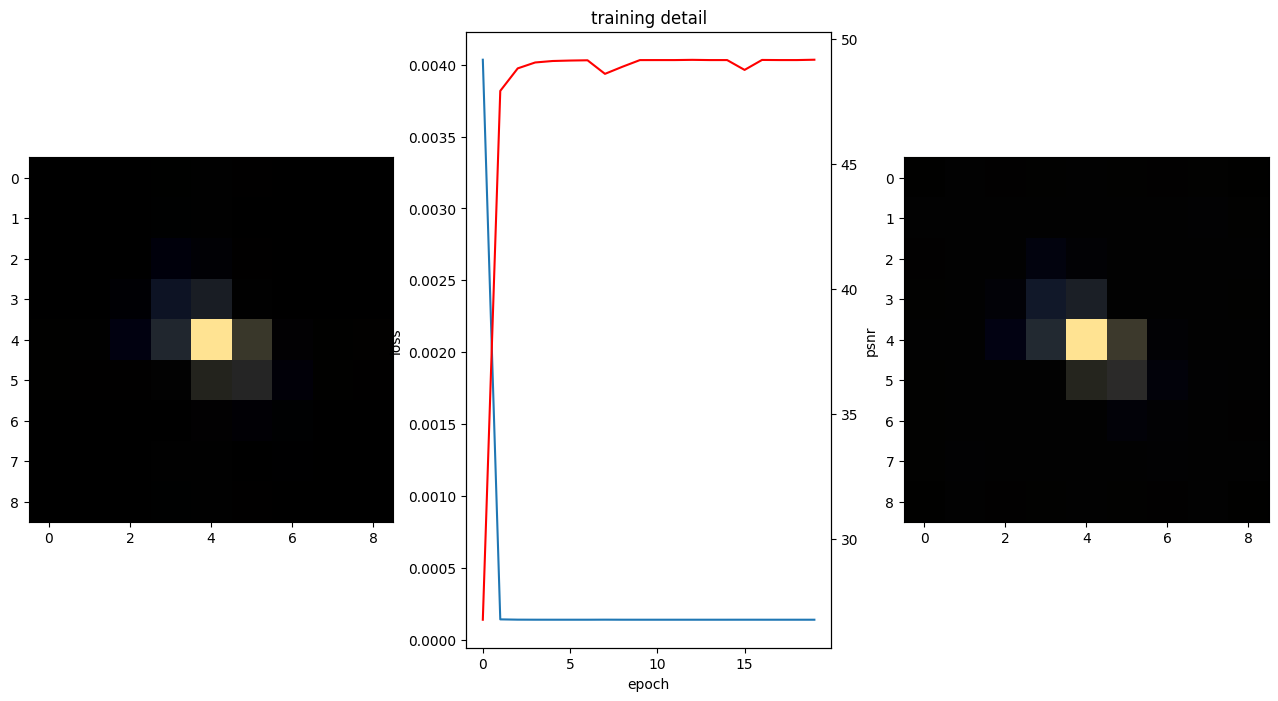

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
num_epochs = 20000
psf_chn = []
for i in range(0,3):
    F = torch.fft.fft2(cof[0,i,:,:])
    G = torch.fft.fft2(cof_deg[0,i,:,:])
    H = G/F

    h = torch.fft.ifft2(H)
    h = torch.fft.fftshift(h)
    h = h[196:205,296:305] # [9, 9]
    h = h.abs()
    h = h.unsqueeze(0)
    psf_chn.append(h.unsqueeze(1))
psf_init = torch.concatenate((psf_chn[0], psf_chn[1], psf_chn[2]),dim=0)
psf_init = psf_init.to(device)
psf_init.requires_grad = True
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
ax1.imshow((psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...] - 
           psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...].min())/
           (psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...].max() - 
           psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy()[::-1, ::-1, ...].min()))

loss_fn = torch.nn.MSELoss().to(device)
cof, cof_deg = cof.to(device), cof_deg.to(device)
optimizer = torch.optim.Adam([psf_init], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_epochs//5, gamma=0.5)

record_freq = 1000
record_log = {'loss':[], 'psf':[], 'psnr':[]}
for iter in range(num_epochs):
    prediction = torch.nn.functional.conv2d(cof, psf_init, padding=int((psf_init.shape[-1]-1)/2), groups=3)
    loss_aux = torch.sum(psf_init) - 3. 
    loss = loss_fn(prediction, cof_deg) + 0.001 * loss_aux
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if iter % record_freq == 0:
        record_log['loss'].append(loss.detach().cpu().item())
        record_log['psf'].append(psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy())
        record_log['psnr'].append(eval_psnr(prediction, cof_deg).cpu().item())
        print('iteration: <{}>, loss: <{}>'.format(iter, loss.detach().cpu().item()))

ax2.plot(range(0, num_epochs//record_freq), np.array(record_log['loss']))
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2 = ax2.twinx()
ax2.plot(range(0, num_epochs//record_freq), np.array(record_log['psnr']), color='red')
ax2.set_ylabel('psnr')
ax3.imshow((record_log['psf'][-1] - record_log['psf'][-1].min())/
           (record_log['psf'][-1].max() - record_log['psf'][-1].min()))
plt.title('training detail')
plt.show()

在频域上进行优化和在空域上是否会有差异？

iteration: <0>, loss: <0.0035346928374864234>
iteration: <1000>, loss: <2.3393688314504637e-06>
iteration: <2000>, loss: <4.4711055092405436e-07>
iteration: <3000>, loss: <1.2252952305019985e-07>
iteration: <4000>, loss: <9.524860606124253e-08>
iteration: <5000>, loss: <2.536740837516806e-08>
iteration: <6000>, loss: <1.1868551563931533e-08>
iteration: <7000>, loss: <2.9512250214815766e-06>
iteration: <8000>, loss: <2.573522597658444e-09>
iteration: <9000>, loss: <1.513965093792211e-09>
iteration: <10000>, loss: <7.369333818751777e-10>
iteration: <11000>, loss: <3.635477890482812e-10>
iteration: <12000>, loss: <6.854843328801466e-09>
iteration: <13000>, loss: <1.1134613417301324e-10>
iteration: <14000>, loss: <5.673620988478428e-11>
iteration: <15000>, loss: <3.9542925843968653e-10>
iteration: <16000>, loss: <4.639815153639597e-10>
iteration: <17000>, loss: <9.51730869711688e-12>
iteration: <18000>, loss: <3.2712827321668665e-09>
iteration: <19000>, loss: <4.53974969591988e-09>


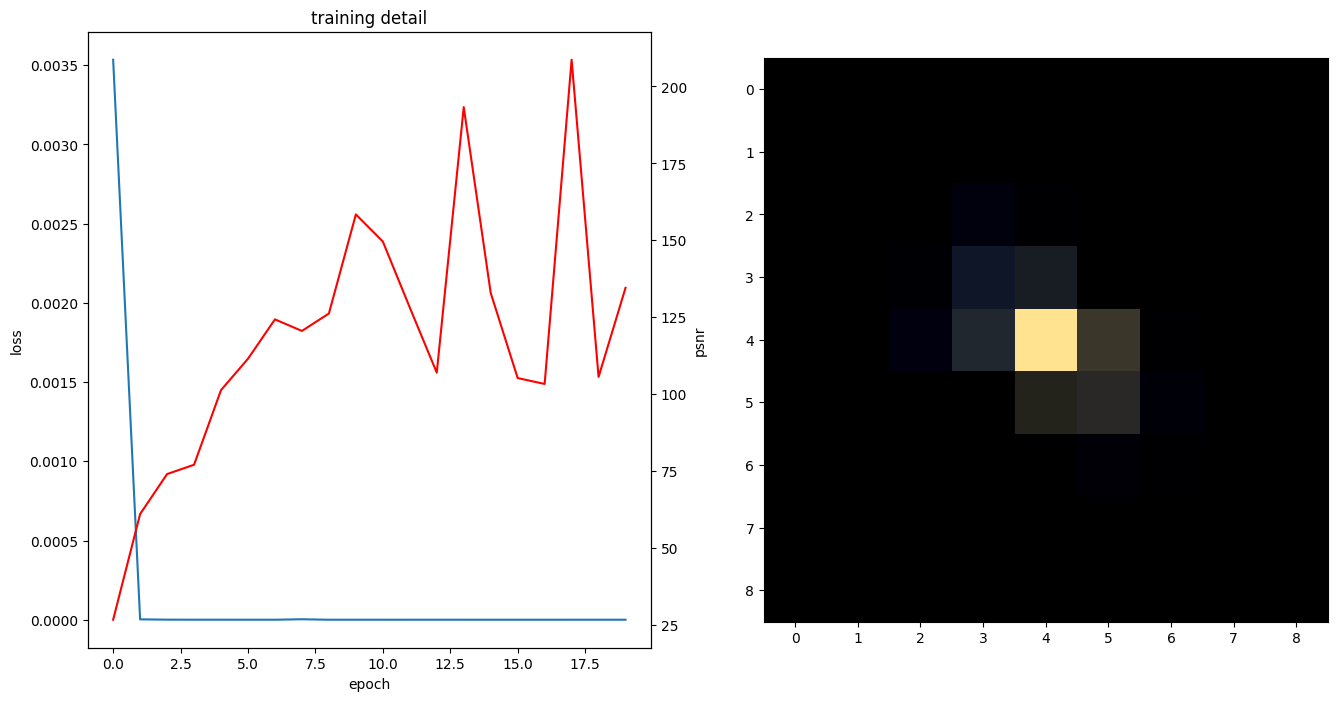

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
num_epochs = 20000
psf_chn = []
for i in range(0,3):
    F = torch.fft.fft2(cof[0,i,:,:])
    G = torch.fft.fft2(cof_deg[0,i,:,:])
    H = G/F

    h = torch.fft.ifft2(H)
    h = torch.fft.fftshift(h)
    h = h[196:205,296:305] # [9, 9]
    h = h.abs()
    h = h.unsqueeze(0)
    psf_chn.append(h.unsqueeze(1))
psf_init = torch.concatenate((psf_chn[0], psf_chn[1], psf_chn[2]), dim=1)
psf_init = psf_init.to(device)
psf_init.requires_grad = True

loss_fn = torch.nn.MSELoss().to(device)
cof, cof_deg = cof.to(device), cof_deg.to(device)
optimizer = torch.optim.Adam([psf_init], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_epochs//5, gamma=0.5)

def fft_blur_forward(org, kernel):
    [A, B] = org.shape[-2:]
    [C, D] = kernel.shape[-2:]
    kernel = torch.rot90(kernel, 2, dims=(-2,-1))
    org = torch.nn.functional.pad(org, [0, D - 1, 0, C - 1])
    kernel = torch.nn.functional.pad(kernel, [0, B - 1, 0, A - 1])
    blur = torch.fft.ifft2(torch.fft.fft2(org) * torch.fft.fft2(kernel)).real
    blur = blur[..., int(C/2):int(C/2)+A, int(D/2):int(D/2)+B]
    return blur

record_freq = 1000
record_log = {'loss':[], 'psf':[], 'psnr':[]}
for iter in range(num_epochs):
    prediction = fft_blur_forward(cof, psf_init)
    loss = loss_fn(prediction, cof_deg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if iter % record_freq == 0:
        record_log['loss'].append(loss.detach().cpu().item())
        record_log['psf'].append(psf_init.detach().squeeze(0).permute(1, 2, 0).cpu().numpy())
        record_log['psnr'].append(eval_psnr(prediction, cof_deg).cpu().item())
        print('iteration: <{}>, loss: <{}>'.format(iter, loss.detach().cpu().item()))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(range(0, num_epochs//record_freq), np.array(record_log['loss']))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1 = ax1.twinx()
ax1.plot(range(0, num_epochs//record_freq), np.array(record_log['psnr']), color='red')
ax1.set_ylabel('psnr')
ax2.imshow((record_log['psf'][-1] - record_log['psf'][-1].min())/
           (record_log['psf'][-1].max() - record_log['psf'][-1].min()))
plt.title('training detail')
plt.show()

可以看到，在我们这个case的优化结果上，在频域进行优化和在空域进行优化差异并不大。那为什么大多传统优化方法都在频域上做呢？

- 主要原因是在PSF变大的时候，频域的乘除速度快于空域的卷积

- 另一个原因是一些其他的裂项操作在频域有解析解，不过现在可以计算微分，只要描述正向过程即可。

数值精度

iteration: <0>, loss: <0.005926778074353933>
iteration: <1000>, loss: <0.00010779158037621528>
iteration: <2000>, loss: <2.46216277446365e-05>
iteration: <3000>, loss: <7.336916496569756e-06>
iteration: <4000>, loss: <4.162558525422355e-06>
iteration: <5000>, loss: <1.3581567372966674e-06>
iteration: <6000>, loss: <6.862866257506539e-07>
iteration: <7000>, loss: <2.439138881982217e-07>
iteration: <8000>, loss: <1.0622133572724124e-07>
iteration: <9000>, loss: <6.113076267411088e-08>
iteration: <10000>, loss: <3.616472454837094e-08>
iteration: <11000>, loss: <3.5042361901105323e-07>
iteration: <12000>, loss: <5.725665719324979e-09>
iteration: <13000>, loss: <3.389981850787649e-09>
iteration: <14000>, loss: <2.122346955957255e-07>
iteration: <15000>, loss: <7.402795598743239e-10>
iteration: <16000>, loss: <3.5179231749893347e-10>
iteration: <17000>, loss: <2.134776105888747e-10>
iteration: <18000>, loss: <1.0897748675686714e-10>
iteration: <19000>, loss: <5.29329254039812e-11>


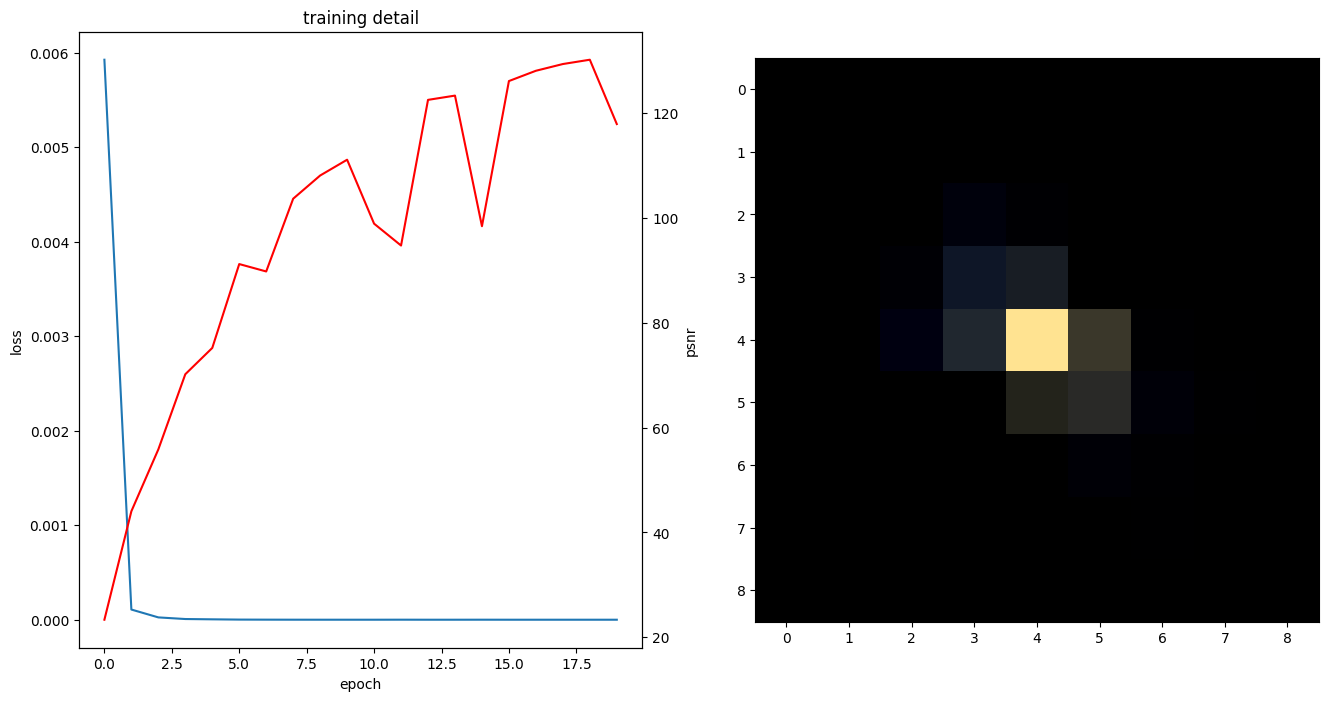

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
num_epochs = 20000
psf_chn = []
for i in range(0,3):
    F = torch.fft.fft2(cof[0,i,:,:])
    G = torch.fft.fft2(cof_deg[0,i,:,:])
    H = G/F

    h = torch.fft.ifft2(H)
    h = torch.fft.fftshift(h)
    h = h[195:204,295:304] # [9, 9]
    h = h.abs()
    h = h.unsqueeze(0)
    psf_chn.append(h.unsqueeze(1))
psf_init = torch.concatenate((psf_chn[0], psf_chn[1], psf_chn[2]),dim=0).to(torch.float32)
psf_init.requires_grad = True

loss_fn = torch.nn.MSELoss().to(device)
cof, cof_deg = cof.to(torch.float32).to(device), cof_deg.to(torch.float32).to(device)
optimizer = torch.optim.Adam([psf_init], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, num_epochs//5, gamma=0.5)

record_freq = 1000
record_log = {'loss':[], 'psf':[], 'psnr':[]}
for iter in range(num_epochs):
    prediction = torch.nn.functional.conv2d(cof, psf_init, padding=int((psf_init.shape[-1]-1)/2), groups=3)
    loss = loss_fn(prediction, cof_deg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if iter % record_freq == 0:
        record_log['loss'].append(loss.detach().cpu().item())
        record_log['psf'].append(psf_init.detach().squeeze(1).permute(1, 2, 0).cpu().numpy())
        record_log['psnr'].append(eval_psnr(prediction, cof_deg).cpu().item())
        print('iteration: <{}>, loss: <{}>'.format(iter, loss.detach().cpu().item()))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(range(0, num_epochs//record_freq), np.array(record_log['loss']))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1 = ax1.twinx()
ax1.plot(range(0, num_epochs//record_freq), np.array(record_log['psnr']), color='red')
ax1.set_ylabel('psnr')
ax2.imshow((record_log['psf'][-1] - record_log['psf'][-1].min())/
           (record_log['psf'][-1].max() - record_log['psf'][-1].min()))
plt.title('training detail')
plt.show()

精度转到float32以后，准确性是下降了一些。不过这一默认的精度对于图像端的复原预测来说已经完全够了。